In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm


In [2]:

if torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

mps


In [3]:
path = "images/birds.png"
im = Image.open(path).convert("RGB")

im_tensor_mps =to_tensor(im).to(device="mps") 


max_dim = 250
_, H, W = im_tensor_mps.shape
scale_factor = max_dim / max(H, W)

new_H = int(H * scale_factor)
new_W = int(W * scale_factor)
im_resized = resize(im_tensor_mps.unsqueeze(0), size=[new_H, new_W], antialias=True).squeeze(0) *2 -1

print(f"rescaled tensor size : {im_resized.shape}")

rescaled tensor size : torch.Size([3, 168, 249])


In [4]:
          # dimension mini au coarse scale
N = 1
current_H, current_W = new_H, new_W
r = 4 / 3               # scaling factor (environ 1.333)
min_dim = 25  
# Calculer N tel que le coarse scale soit >= min_dim
while current_H >= min_dim and current_W >= min_dim:
    N += 1
    current_H = int(current_H / r)
    current_W = int(current_W / r)
N

8

In [5]:
scales = [im_resized.unsqueeze(0)]    # niveau 0 = fine

for i in range(1, N):
    prev = scales[-1]
    _, _, h, w = prev.shape
    new_h = max(int(h / r), 1)
    new_w = max(int(w / r), 1)
    down = resize(prev, size=[new_h, new_w], antialias=True)
    scales.append(down)


Number of scales N = 8
Scaling factor r = 1.333
Scale 0 : torch.Size([1, 3, 168, 249])


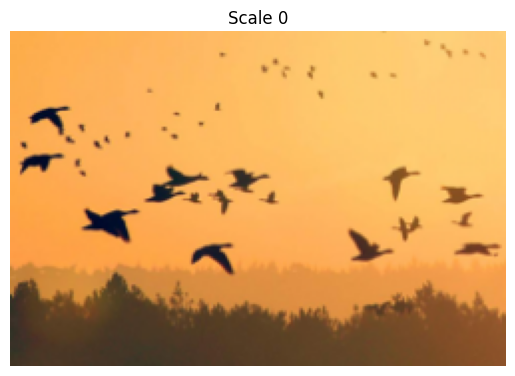

Scale 1 : torch.Size([1, 3, 126, 186])


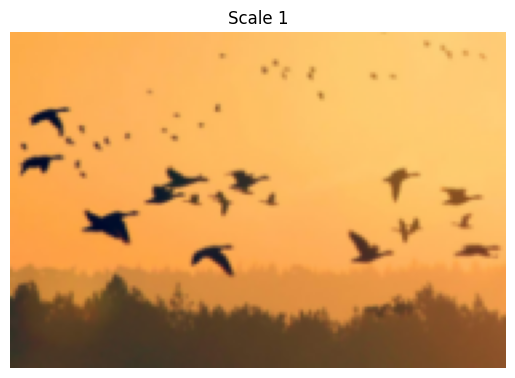

Scale 2 : torch.Size([1, 3, 94, 139])


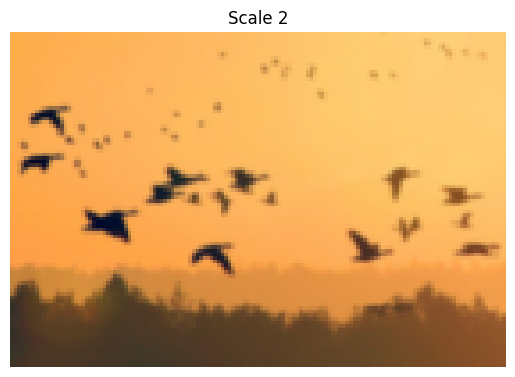

Scale 3 : torch.Size([1, 3, 70, 104])


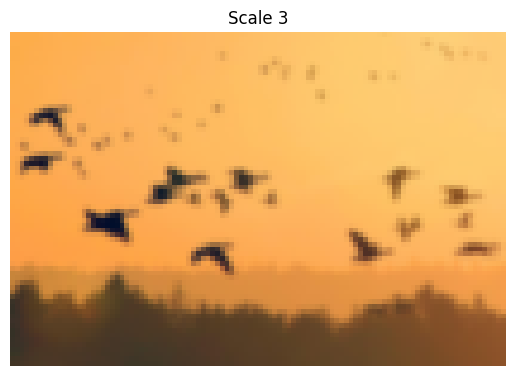

Scale 4 : torch.Size([1, 3, 52, 78])


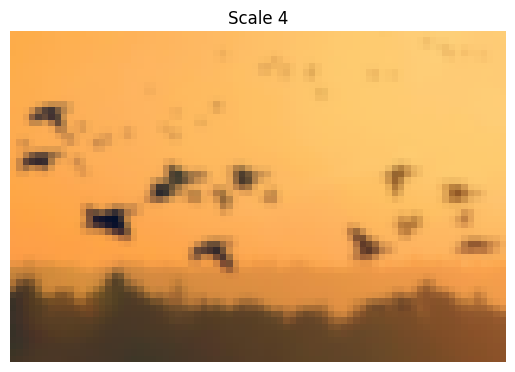

Scale 5 : torch.Size([1, 3, 39, 58])


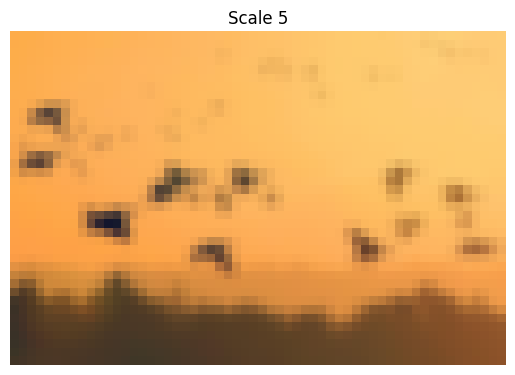

Scale 6 : torch.Size([1, 3, 29, 43])


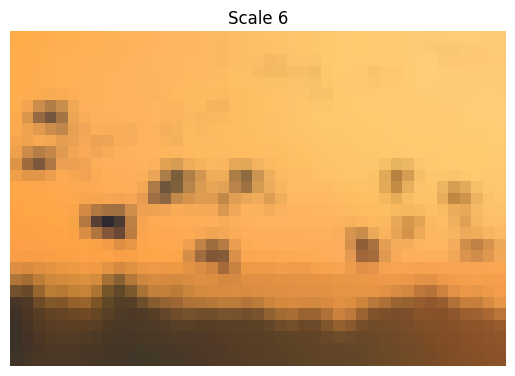

Scale 7 : torch.Size([1, 3, 21, 32])


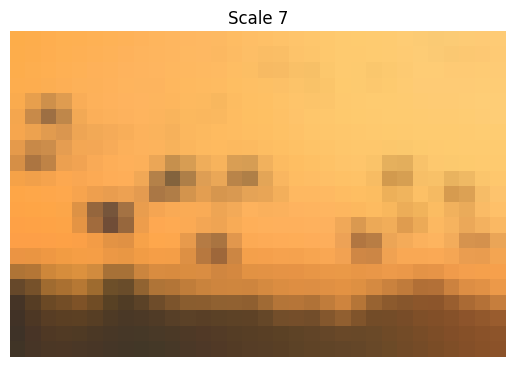

In [6]:
def pil_from_minus1to1(t):
    """
    Convertit un tenseur [-1,1] (CHW ou 1,C,H,W) en PIL Image.
    """
    t = t.squeeze(0) if t.dim() == 4 else t          # B×C×H×W → C×H×W
    t = ((t.clamp(-1, 1) + 1) / 2)                   # [-1,1] → [0,1]
    return to_pil_image(t.cpu())



print(f"Number of scales N = {N}")
print(f"Scaling factor r = {r:.3f}")
for i, im_scale in enumerate(scales):
    print(f"Scale {i} : {im_scale.shape}")
    plt.imshow(pil_from_minus1to1(im_scale.squeeze().cpu()))
    plt.axis('off')
    plt.title(f"Scale {i}")
    plt.show()


In [7]:
class Generator(nn.Module):
    
    def __init__(self,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.n_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            # Last conv layer outputs 3 channels (RGB), no batchnorm or activation
            nn.Conv2d(self.n_hidden, 3, 3, padding=1),
            nn.Tanh()
        )
        
    def forward(self,input):
        return self.main(input)

+ Générations des generateurs/discriminateurs

In [8]:
hidden_lowest_dim = 32
Genarators = []

for i in range(len(scales)):
    r = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(r//4)).to(device))

    
Genarators.reverse()

for gen in Genarators : 
     print(gen.n_hidden)



32
32
32
64
64
64
64
128


+ Boucle d'entrainement 

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


for G in Genarators:
    G.apply(weights_init)


scale 7:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 7 it 0]  LR=5.00e-04  W2=3.695  Adv=0.617


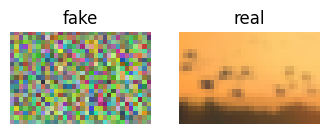

scale 7:  10%|▉         | 199/2000 [00:19<02:08, 13.99it/s]

[scale 7 it 200]  LR=5.00e-04  W2=0.016  Adv=3.891


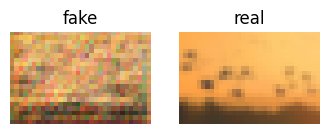

scale 7:  20%|█▉        | 399/2000 [00:33<01:52, 14.27it/s]

[scale 7 it 400]  LR=5.00e-04  W2=0.009  Adv=4.578


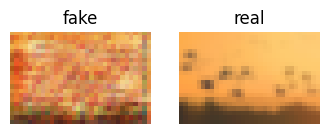

scale 7:  30%|██▉       | 599/2000 [00:47<01:34, 14.84it/s]

[scale 7 it 600]  LR=5.00e-04  W2=0.009  Adv=6.328


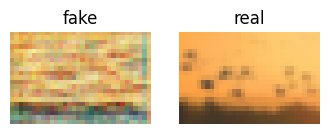

scale 7:  40%|███▉      | 799/2000 [01:03<01:29, 13.47it/s]

[scale 7 it 800]  LR=5.00e-04  W2=0.003  Adv=3.093


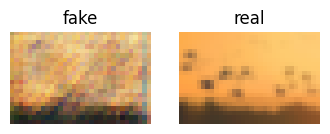

scale 7:  50%|████▉     | 999/2000 [01:18<01:11, 14.08it/s]

[scale 7 it 1000]  LR=5.00e-04  W2=0.005  Adv=8.907


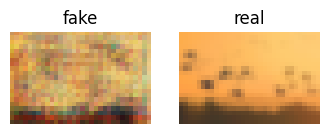

scale 7:  60%|█████▉    | 1199/2000 [01:33<00:58, 13.73it/s]

[scale 7 it 1200]  LR=5.00e-04  W2=0.002  Adv=10.117


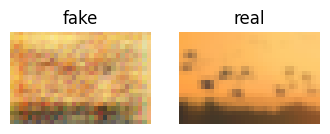

scale 7:  70%|██████▉   | 1399/2000 [01:47<00:50, 11.97it/s]

[scale 7 it 1400]  LR=5.00e-04  W2=0.002  Adv=7.465


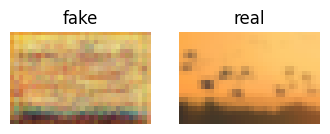

scale 7:  80%|███████▉  | 1599/2000 [02:02<00:27, 14.37it/s]

[scale 7 it 1600]  LR=5.00e-05  W2=0.001  Adv=5.532


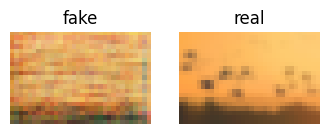

scale 7:  90%|████████▉ | 1799/2000 [02:16<00:14, 13.62it/s]

[scale 7 it 1800]  LR=5.00e-05  W2=0.001  Adv=6.556


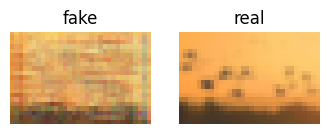

scale 7: 100%|█████████▉| 1999/2000 [02:30<00:00, 14.41it/s]

[scale 7 it 1999]  LR=5.00e-05  W2=0.001  Adv=8.777


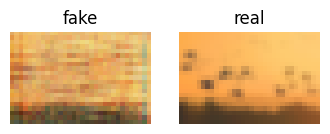

AttributeError: 'Generator' object has no attribute 'out_channels'

In [10]:
import math
import torch
import torch.nn.functional as F
from torch import optim, nn
from torchvision import models
from tqdm import tqdm
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1) Math & extraction de patches
# -------------------------------------------------------------------
def sqrtm_newton(A: torch.Tensor, n_iter: int = 5, eps: float = 1e-10) -> torch.Tensor:
    tr = A.trace()
    Y  = A / (tr + eps)
    I  = torch.eye(A.size(0), device=device, dtype=A.dtype)
    Z  = I.clone()
    for _ in range(n_iter):
        T  = 0.5 * (3*I - Z @ Y)
        Y, Z = Y @ T, T @ Z
    return Y * torch.sqrt(tr + eps)

def _cov(x: torch.Tensor, mean: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    xc = x - mean
    return xc.T @ xc / (xc.size(0) - 1) + eps * torch.eye(xc.size(1), device=x.device, dtype=x.dtype)

def extract_patches(img: torch.Tensor, patch: int, stride: int, max_patches: int = 2000) -> torch.Tensor:
    B, C, H, W = img.shape
    patches = (
        img.unfold(2, patch, stride)
           .unfold(3, patch, stride)
           .contiguous()
           .view(-1, C * patch * patch)
    )
    if patches.size(0) > max_patches:
        idx = torch.randperm(patches.size(0), device=img.device)[:max_patches]
        patches = patches[idx]
    return patches

# -------------------------------------------------------------------
# 2) PatchCNNEncoder léger
# -------------------------------------------------------------------
class PatchCNNEncoder(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=64, n_layers=3):
        super().__init__()
        layers = []
        ch = in_channels
        for _ in range(n_layers):
            layers += [
                nn.Conv2d(ch, hidden_dim, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(inplace=True)
            ]
            ch = hidden_dim
        self.features = nn.Sequential(*layers)
        self.pool     = nn.AdaptiveAvgPool2d(1)
    def forward(self, patches: torch.Tensor) -> torch.Tensor:
        nP, D = patches.shape
        C = 3
        p = int(math.sqrt(D // C))
        x = patches.view(nP, C, p, p)
        x = self.features(x)
        x = self.pool(x)
        return x.view(nP, -1)

# -------------------------------------------------------------------
# 3) PatchGAN Discriminator
# -------------------------------------------------------------------
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, base=64, n_layers=3):
        super().__init__()
        layers = []
        ch = in_channels
        for i in range(n_layers):
            out = base * (2**i)
            layers += [
                nn.utils.spectral_norm(
                    nn.Conv2d(ch, out, kernel_size=4, stride=2, padding=1)
                ),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            ch = out
        layers += [ nn.utils.spectral_norm(
                        nn.Conv2d(ch, 1, kernel_size=4, padding=1)
                    ) ]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)  # (B,1,H',W')

# -------------------------------------------------------------------
# 4) Perceptual loss (VGG) & TV-loss
# -------------------------------------------------------------------
vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:16].eval().to(device)
for p in vgg.parameters(): p.requires_grad_(False)

def perceptual_loss(x, y):
    # x,y in [-1,1] -> [0,1]
    fx = vgg((x + 1) * 0.5)
    fy = vgg((y + 1) * 0.5)
    return F.l1_loss(fx, fy)

def tv_loss(x):
    return ((x[:, :, :, :-1] - x[:, :, :, 1:]).abs().mean() +
            (x[:, :, :-1, :] - x[:, :, 1:, :]).abs().mean())

# -------------------------------------------------------------------
# 5) Multi-patch W2 loss avec encoder
# -------------------------------------------------------------------
def w2_gaussian_multi_patch(
        real: torch.Tensor,
        fake: torch.Tensor,
        patch_sizes=(3, 7, 11),
        stride_ratio=0.5,
        encoder=None,
        max_patches=2000
    ) -> torch.Tensor:
    total = 0.0
    for p in patch_sizes:
        s  = max(1, int(p * stride_ratio))
        pr = extract_patches(real, p, s, max_patches)
        pf = extract_patches(fake, p, s, max_patches)
        if encoder is not None:
            pr = encoder(pr)
            pf = encoder(pf)
        mr, mg = pr.mean(0), pf.mean(0)
        Cr, Cg = _cov(pr, mr), _cov(pf, mg)
        Cr_s = sqrtm_newton(Cr)
        inner = sqrtm_newton(Cr_s @ Cg @ Cr_s)
        total += (mr - mg).pow(2).sum() + torch.trace(Cr + Cg - 2 * inner)
    return total / len(patch_sizes)

# -------------------------------------------------------------------
# 6) Reconstruction hiérarchique
# -------------------------------------------------------------------
@torch.no_grad()
def regenerate_prev_full(k, Generators, scales, sigma_n, device):
    N = len(scales)
    if k == N-1:
        return torch.zeros_like(scales[k]).to(device)
    img = torch.zeros_like(scales[-1]).to(device)
    z   = torch.randn_like(img) * sigma_n[N-1]
    img = Generators[-1](z)
    for s in range(N-2, k, -1):
        img_up = F.interpolate(img, size=scales[s].shape[2:], mode='bilinear', align_corners=False)
        z      = torch.randn_like(img_up) * sigma_n[s]
        img    = Generators[s](z + img_up) + img_up
    return F.interpolate(img, size=scales[k].shape[2:], mode='bilinear', align_corners=False)

# -------------------------------------------------------------------
# 7) Boucle d'entraînement “tout-en-un”
# -------------------------------------------------------------------

# → À définir avant : device, Generators (list), Discriminators/scales, pil_from_minus1to1()

N      = len(scales)

# hyper-params
lr             = 5e-4
betas          = (0.5, 0.999)
iter_per_scale = 2000
alpha_rec      = 5.0
beta_sigma     = 0.2
alpha_adv      = 1.0
alpha_perc     = 0.1
alpha_tv       = 0.01
patch_sizes    = (3, 7, 11)
stride_ratio   = 0.5
max_patches    = 2000
debug          = True

# instantiate encoder & discriminators
encoder_cnn   = PatchCNNEncoder().to(device)
Discriminators = [PatchDiscriminator().to(device) for _ in range(N)]

# optim & schedulers
optimizer_G, optimizer_D, scheduler_G = [], [], []
for k in range(N):
    # G + encoder
    optG = optim.Adam(
        list(Genarators[k].parameters()) + list(encoder_cnn.parameters()),
        lr=lr, betas=betas
    )
    optimizer_G.append(optG)
    scheduler_G.append(optim.lr_scheduler.StepLR(optG, step_size=1500, gamma=0.1))
    # D
    optD = optim.Adam(Discriminators[k].parameters(), lr=lr, betas=betas)
    optimizer_D.append(optD)

z_star    = torch.randn_like(scales[-1]).to(device)
sigma_n   = [1.0] * N
x_rec     = [None] * N
gen_image = [torch.zeros_like(scales[-1]).to(device)]

bce = nn.BCEWithLogitsLoss()

for n in range(N):
    k       = N - n - 1
    Gk      = Genarators[k].train()
    Dk      = Discriminators[k].train()
    xk_real = scales[k].to(device)
    optG    = optimizer_G[k]
    optD    = optimizer_D[k]

    # warm-start
    if k < N-1:
        if any(isinstance(m, nn.Conv2d) and m.out_channels == next(Genarators[k+1].modules()).out_channels
               for m in Gk.modules()):
            Gk.load_state_dict(Genarators[k+1].state_dict(), strict=True)

    # σₙ
    if k < N-1:
        up = F.interpolate(x_rec[k+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
        with torch.no_grad():
            num   = F.mse_loss(up, xk_real)
            denom = F.mse_loss(torch.zeros_like(xk_real), xk_real)
        sigma_n[k] = beta_sigma * torch.sqrt(num / denom)
    else:
        sigma_n[k] = 1.0

    for it in tqdm(range(iter_per_scale), desc=f"scale {k}", leave=False):
        # prépare prev_img
        with torch.no_grad():
            prev_img = regenerate_prev_full(k, Genarators, scales, sigma_n, device)

        # ---- D-step ----
        optD.zero_grad()
        real_logits = Dk(xk_real)
        # fake détaché
        z_det = torch.randn_like(prev_img) * sigma_n[k]
        fake_det = Gk(z_det + prev_img).detach() + prev_img
        fake_logits = Dk(fake_det)
        loss_D = 0.5 * (bce(real_logits, torch.ones_like(real_logits)) +
                        bce(fake_logits, torch.zeros_like(fake_logits)))
        loss_D.backward()
        optD.step()

        # ---- G-step ----
        optG.zero_grad()
        z = torch.randn_like(prev_img) * sigma_n[k]
        fake = Gk(z + prev_img) + prev_img

        # 1) W2 multi-patch
        loss_w2 = w2_gaussian_multi_patch(xk_real, fake,
                                          patch_sizes, stride_ratio,
                                          encoder_cnn, max_patches)
        # 2) adversarial
        logits_fake = Dk(fake)
        loss_adv    = bce(logits_fake, torch.ones_like(logits_fake))
        # 3) reconstruction
        if k == N-1:
            rec_out = Gk(z_star)
        else:
            up_rec = F.interpolate(x_rec[k+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            rec_out = Gk(up_rec) + up_rec
        loss_rec  = F.mse_loss(rec_out, xk_real)
        # 4) perceptual
        loss_perc = perceptual_loss(rec_out, xk_real)
        # 5) TV-loss
        loss_tv   = tv_loss(fake)

        # total G loss
        lossG = loss_w2 \
              + alpha_adv * loss_adv \
              + alpha_rec * loss_rec \
              + alpha_perc * loss_perc \
              - alpha_tv  * loss_tv
        lossG.backward()
        optG.step()
        scheduler_G[k].step()

        # debug visuel
        if debug and (it % 200 == 0 or it == iter_per_scale-1):
            lr_now = optG.param_groups[0]['lr']
            print(f"[scale {k} it {it}]  LR={lr_now:.2e}  W2={loss_w2.item():.3f}  Adv={loss_adv.item():.3f}")
            with torch.no_grad():
                plt.figure(figsize=(4,2))
                plt.subplot(1,2,1)
                plt.imshow(pil_from_minus1to1(fake[0].cpu())); plt.axis('off'); plt.title('fake')
                plt.subplot(1,2,2)
                plt.imshow(pil_from_minus1to1(xk_real[0].cpu())); plt.axis('off'); plt.title('real')
                plt.show()

    # figer Gk & stocker
    with torch.no_grad():
        gen_image.append(fake.detach())
        if k == N-1:
            x_rec[k] = Gk(z_star)
        else:
            upk = F.interpolate(x_rec[k+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            x_rec[k] = Gk(upk) + upk
        Gk.eval()
        for p in Gk.parameters():
            p.requires_grad_(False)


SAVING GENERATORS AND OR LOADING OTHERS

In [ ]:
# ==== SAVE GENERATORS ========================================================
import os, datetime, torch, json

model_name = "no_recloss"                        # ⬅️  choisis ton nom
model_dir  = os.path.join("models", model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")

if os.path.exists(model_dir):
    print(f"ATTENTION : Un modèle nommé '{model_name}' existe déjà dans '{model_dir}'.")
    print("   → Choisis un autre nom pour ne pas l'écraser.")
else:
    os.makedirs(model_dir, exist_ok=True)

    # 1) sauvegarde des poids : liste d'état (un par G_k)
    torch.save([G.state_dict() for G in Genarators], weights_fp)

    # 2) petit fichier description (texte lisible)
    description = {
        "date"           : datetime.datetime.now().isoformat(timespec="seconds"),
        "N"              : N,
        "lambda_gp"      : lambda_gp,
        "lr"             : lr,
        "betas"          : betas,
        "n_Discriminator": n_Discriminator,
        "n_Generator"    : n_Generator,
        "iter_per_scale" : iter_per_scale,
        "alpha_rec"      : alpha_rec,
        "beta_sigma"     : beta_sigma,
        "comment"        : "Sin Gan classique sans rec loss et sans padding",
    }
    with open(descr_fp, "w", encoding="utf-8") as f:
        for k, v in description.items():
            f.write(f"{k}: {v}\n")

    print(f"Générateurs sauvegardés dans  {weights_fp}")
    print(f"Description créée          -> {descr_fp}")


In [ ]:
# ===================== LOAD A CHECKPOINT, WHATEVER IS IN MEMORY =====================
import os, torch

# --- (1) nom du modèle à charger -----------------------------------------------------
model_name = "basic"                  # ← remplace par le tien
model_dir  = os.path.join("models", model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")

if not os.path.exists(weights_fp):
    raise FileNotFoundError(f"Impossible de trouver le fichier : {weights_fp}")

# --- (2) on lit la liste de state_dict ----------------------------------------------
state_list = torch.load(weights_fp, map_location="cpu")   # toujours sur CPU d'abord

print(f"{len(state_list)} générateurs trouvés dans le checkpoint")

# (facultatif) on affiche le petit fichier description
if os.path.isfile(descr_fp):
    print("─── Description.txt ───")
    with open(descr_fp, encoding="utf-8") as f:
        print(f.read().strip())
    print("────────────────────────\n")

# --- (3) fonction helper : recrée un Generator adapté au state_dict -----------------
def build_generator_from_state(sd, device="cpu"):
    """
    Reconstruit un objet Generator avec la bonne dimension cachée
    en regardant le 1er conv du state_dict.
    """
    # on détecte le nombre de canaux de sortie du premier conv
    # (selon ton code : 'head.conv.weight' ou 'main.0.weight')
    for key in sd.keys():
        if key.endswith(".weight") and sd[key].dim() == 4:   # conv 2d
            n_hidden = sd[key].shape[0]   
            print("n_hidden found", n_hidden)# out_channels
            break
    else:
        raise KeyError("Impossible d'inférer n_hidden depuis le state_dict.")

    G = Generator(n_hidden).to(device)
    G.load_state_dict(sd, strict=True)
    G.eval()
    for p in G.parameters():
        p.requires_grad_(False)
    return G

# --- (4) on construit la liste des générateurs chargés --------------------------------
device = torch.device("mps" if torch.mps.is_available() else "cpu")
loaded_generators = [build_generator_from_state(sd, device=device) for sd in state_list]

print(f"{len(loaded_generators)} générateurs instanciés → liste 'loaded_generators'")


In [28]:
@torch.no_grad()
def generate_multiscale(start_scale: int = N - 1,Generators = Genarators):
    """
    start_scale = 0  → on ne renouvelle le bruit qu’à la fine scale
    start_scale = N-1→ on renouvelle le bruit à toutes les échelles
    """
    # Génération totale
    if start_scale == N-1 : 
        h, w = scales[-1].shape[2:]
        gen_image = [torch.zeros((1, 3, h, w), device=device)]

         # 2. on remonte coarse → fine
        for i in range(N):
            k = N - 1 - i                    
        
            prev = gen_image[-1]
            if prev.shape[2:] != scales[k].shape[2:]:
                prev = F.interpolate(prev, size=scales[k].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * sigma_n[k]
            

            x_k = Generators[k](z + prev) + prev
            gen_image.append(x_k)

        

    else : 
        low = scales[start_scale+1] 
        up = F.interpolate(low, size=scales[start_scale].shape[2:],
                                    mode='bilinear', align_corners=False)
        gen_image = [up]

         # 2. on remonte coarse → fine
        for scale in range(start_scale,-1,-1):
                            
            prev = gen_image[-1]
            if prev.shape[2:] != scales[scale].shape[2:]:
                prev = F.interpolate(prev, size=scales[scale].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * sigma_n[scale]
            x_k = Genarators[scale](z + prev) + prev
            gen_image.append(x_k)

    
    return gen_image[1:]
        
    


In [ ]:
# 1. Collecter toutes les images pour connaître la taille de la grille
rows      = []                 # liste des listes d’images (Tensor)
max_cols  = 0
for s in range(N):
    imgs = generate_multiscale(start_scale=s,Generators=loaded_generators)   # list[Tensor]
    rows.append(imgs)
    max_cols = max(max_cols, len(imgs))

# 2. Créer la figure
cell = 3.0                     # taille (pouces) d’une cellule
fig_w, fig_h = cell * max_cols, cell * N
fig, axes = plt.subplots(N, max_cols, figsize=(fig_w, fig_h), squeeze=False)

# 3. Remplir le tableau
for r, (s, imgs) in enumerate(zip(range(N), rows)):
    for c in range(max_cols):
        ax = axes[r, c]

        if c < len(imgs):
            img_pil = pil_from_minus1to1(imgs[c].cpu().squeeze())
            
            ax.imshow(img_pil)
            ax.set_title(f"s={s}  i={c}", fontsize=8)
        else:
            ax.axis('off')          # cellule vide

        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
import torchvision.utils as vutils
import os, time

# dossier de sortie
out_dir = "models/no_recloss/outputs"
os.makedirs(out_dir, exist_ok=True)

# Nombre de générations
K = 8
final_imgs = []
for k in range(K):
    imgs = generate_multiscale(start_scale=N-1,Generators=loaded_generators)
    final_imgs.append(imgs[-1].cpu().squeeze())      # dernière image

# affichage + sauvegarde
cell = 3.0
fig, axes = plt.subplots(1, K, figsize=(cell*K, cell), squeeze=False)

for idx, (ax, img) in enumerate(zip(axes[0], final_imgs), 1):
    # plot
    ax.imshow(pil_from_minus1to1(img))
    ax.set_title(f"sample {idx}", fontsize=8)
    ax.set_xticks([]); ax.set_yticks([])

    # sauvegarde
    img_01 = ((img.clamp(-1, 1) + 1) / 2)            # [-1,1] → [0,1]
    filename = os.path.join(
        out_dir, f"gen_{time.strftime('%Y%m%d_%H%M%S')}_{idx}.png"
    )
    vutils.save_image(img_01, filename)
    print(f"saved → {filename}")

plt.tight_layout()
plt.show()


Reconstruction de XREC

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_reconstructions(x_rec, scales):
    for i, rec in enumerate(x_rec):
        if rec is None:
            continue
        img = rec.detach().cpu().squeeze()
        plt.figure(figsize=(4,4))
        plt.title(f"Reconstruction scale {i}")
        plt.imshow(pil_from_minus1to1(img))
        plt.axis('off')
        plt.show()

plot_reconstructions(x_rec[1:],scales)